## Business Problem

Customer churn is a critical issue for telecom companies, directly impacting revenue and customer lifetime value.
Building on the exploratory analysis, the goal of this step is to develop a baseline churn prediction model
that identifies at-risk customers and quantifies the impact of key drivers such as contract type,
internet service, tenure, and add-on adoption.

## Data Loading

In this step, we load the raw Telco Customer Churn dataset and run quick sanity checks
to confirm the dataset structure, data types, and the target (`Churn`) distribution.
This establishes a baseline before any preprocessing or modeling.

In [48]:
import pandas as pd
import numpy as np
import warnings

from pandas.errors import Pandas4Warning

warnings.simplefilter(action='ignore', category=Pandas4Warning)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt


In [30]:
pd.set_option("display.max_columns", None)

path = "../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(path)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [31]:
df.shape

(7043, 21)

In [32]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  7043 non-null   str    
 17  Paymen

In [33]:
df["Churn"].value_counts(dropna=False)

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [34]:
df["Churn"].value_counts(normalize=True).round(4)

Churn
No     0.7346
Yes    0.2654
Name: proportion, dtype: float64

## Data Cleaning and Target Encoding

Before building a churn prediction model, we perform minimal data cleaning
and encode the target variable. The goal is to ensure correct data types
and a machine-learning–ready target without introducing unnecessary transformations.

### Handling data types and missing values

The `TotalCharges` column contains numeric values stored as strings,
including empty strings for customers with zero tenure.
These records correspond to new customers and are handled accordingly.

In [35]:
df["TotalCharges"] = df["TotalCharges"].str.strip()

df["TotalCharges"] = df["TotalCharges"].replace("", "0")

df["TotalCharges"] = df["TotalCharges"].astype(float)

In [36]:
df[["tenure", "MonthlyCharges", "TotalCharges"]].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


### Target variable encoding

The churn prediction task is formulated as a binary classification problem.
The target variable `Churn` is encoded as:
- 1 — customer churned
- 0 — customer retained

In [37]:
df["churn_target"] = (df["Churn"] == "Yes").astype(int)

df["churn_target"].value_counts(normalize=True).round(4)

churn_target
0    0.7346
1    0.2654
Name: proportion, dtype: float64

### Removing non-informative identifiers

Customer identifiers do not carry predictive value and are removed
to avoid leakage or noise in the modeling process.

In [38]:
df = df.drop(columns=["customerID"])

## Feature Set Definition

In this step, we define the modeling target and select input features.
The focus is on business-relevant attributes that can be used to identify churn risk
without relying on identifiers or leaking information.

In [39]:
target = "churn_target"

drop_cols = ["Churn", target]

X = df.drop(columns=drop_cols)
y = df[target]

X.shape, y.shape

((7043, 19), (7043,))

### Quick data check

Before encoding, we check for missing values and confirm feature types
(numerical vs categorical). This helps define the preprocessing pipeline.

In [40]:
X.isna().sum().sort_values(ascending=False).head(15)

gender              0
DeviceProtection    0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
OnlineBackup        0
SeniorCitizen       0
OnlineSecurity      0
InternetService     0
MultipleLines       0
PhoneService        0
dtype: int64

In [41]:
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

cat_cols, num_cols

(['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'],
 ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'])

### Notes

- Categorical features will be one-hot encoded.
- Numerical features will be scaled for Logistic Regression.
- We keep the feature set simple and interpretable to align with business insights from the BI dashboard.

## Preprocessing and Train-Test Split

Before training the model, we prepare a preprocessing pipeline.
Categorical features are one-hot encoded, while numerical features are scaled.
The dataset is then split into training and test sets to enable unbiased evaluation.

### Preprocessing strategy

- Categorical features are one-hot encoded to convert them into numeric format.
- Numerical features are standardized to improve model stability.
- A unified preprocessing pipeline ensures consistent transformations
  across training and test data.

In [43]:
categorical_transformer = OneHotEncoder(
    drop="first",
    handle_unknown="ignore"
)

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, cat_cols),
        ("num", numerical_transformer, num_cols),
    ]
)

### Train-test split

The dataset is split into training and test sets.
Stratification is applied to preserve the churn distribution across both sets.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((5282, 19), (1761, 19))

## Model Training — Logistic Regression

We start with a baseline Logistic Regression model.
This model is widely used for churn prediction due to its interpretability
and ability to quantify the impact of individual features on churn risk.

### Model configuration

Logistic Regression is trained with class balancing to account for the
moderate class imbalance in the churn target.
This helps the model focus on identifying churned customers rather than
optimizing overall accuracy.

In [46]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", log_reg)
    ]
)

In [47]:
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

### Training completed

The Logistic Regression model has been trained on the preprocessed training data.
In the next step, we evaluate model performance with a focus on churn recall
and overall discrimination ability.

## Model Evaluation

The model is evaluated using multiple metrics to assess its effectiveness
in identifying churned customers. Given the business context, special attention
is paid to recall for the churn class, as missing a churner is more costly
than incorrectly flagging a retained customer.

In [49]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

### Confusion Matrix

The confusion matrix provides a breakdown of correct and incorrect predictions,
highlighting how well the model identifies churned customers.

In [50]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[949, 345],
       [ 95, 372]])

### Classification Report

Precision, recall, and F1-score are reported for both classes.
Recall for the churn class is particularly important for evaluating
the model's usefulness in a retention context.

In [51]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.909     0.733     0.812      1294
           1      0.519     0.797     0.628       467

    accuracy                          0.750      1761
   macro avg      0.714     0.765     0.720      1761
weighted avg      0.806     0.750     0.763      1761



### ROC-AUC Score

ROC-AUC measures the model’s ability to discriminate between churned
and retained customers across all classification thresholds.

In [52]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc

0.8461504092351787

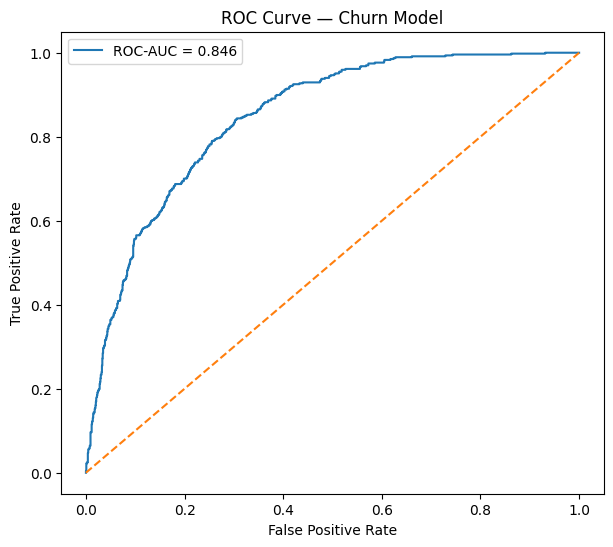

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Churn Model")
plt.legend()
plt.show()

## Model Interpretation — Key Churn Drivers

To make the churn model actionable, we analyze the model coefficients
to understand which features increase or decrease the likelihood of churn.
This step connects the machine learning results with business insights
and findings from the BI analysis.

In [54]:
# Get feature names after preprocessing
feature_names = model.named_steps["preprocessor"].get_feature_names_out()

coef = model.named_steps["classifier"].coef_[0]

coef_df = (
    pd.DataFrame({
        "feature": feature_names,
        "coefficient": coef
    })
    .assign(abs_coef=lambda x: x["coefficient"].abs())
    .sort_values("abs_coef", ascending=False)
)

coef_df.head(15)

,feature,coefficient,abs_coef
21,cat__Contract_Two year,-1.356745,1.356745
6,cat__InternetService_Fiber optic,1.174689,1.174689
27,num__tenure,-1.161963,1.161963
20,cat__Contract_One year,-0.718464,0.718464
28,num__MonthlyCharges,-0.538206,0.538206
29,num__TotalCharges,0.517896,0.517896
19,cat__StreamingMovies_Yes,0.440769,0.440769
22,cat__PaperlessBilling_Yes,0.371441,0.371441
24,cat__PaymentMethod_Electronic check,0.366069,0.366069
17,cat__StreamingTV_Yes,0.355510,0.355510


### Interpreting coefficients

Positive coefficients increase the probability of churn,
while negative coefficients reduce churn risk.
The magnitude of a coefficient reflects the strength of the effect.

In [55]:
coef_df.sort_values("coefficient", ascending=False).head(10)

,feature,coefficient,abs_coef
6,cat__InternetService_Fiber optic,1.174689,1.174689
29,num__TotalCharges,0.517896,0.517896
19,cat__StreamingMovies_Yes,0.440769,0.440769
22,cat__PaperlessBilling_Yes,0.371441,0.371441
24,cat__PaymentMethod_Electronic check,0.366069,0.366069
17,cat__StreamingTV_Yes,0.355510,0.355510
5,cat__MultipleLines_Yes,0.308604,0.308604
26,num__SeniorCitizen,0.073712,0.073712
25,cat__PaymentMethod_Mailed check,0.059042,0.059042
13,cat__DeviceProtection_Yes,0.031533,0.031533


In [56]:
coef_df.sort_values("coefficient", ascending=True).head(10)

,feature,coefficient,abs_coef
21,cat__Contract_Two year,-1.356745,1.356745
27,num__tenure,-1.161963,1.161963
20,cat__Contract_One year,-0.718464,0.718464
28,num__MonthlyCharges,-0.538206,0.538206
9,cat__OnlineSecurity_Yes,-0.353341,0.353341
3,cat__PhoneService_Yes,-0.294904,0.294904
15,cat__TechSupport_Yes,-0.287791,0.287791
2,cat__Dependents_Yes,-0.229576,0.229576
4,cat__MultipleLines_No phone service,-0.205803,0.205803
18,cat__StreamingMovies_No internet service,-0.187698,0.187698


### Business interpretation of model coefficients

The model highlights several strong and intuitive churn drivers that closely align
with insights from the BI analysis.

Churn risk is significantly higher for customers using fiber optic internet,
indicating sensitivity to pricing and perceived service value.
High total charges further amplify this risk, especially among customers
with shorter tenure.

Behavioral signals such as electronic check payments and paperless billing
are also associated with increased churn, suggesting lower customer commitment.

On the retention side, long-term contracts and customer tenure emerge as the
strongest protective factors against churn.
Additional services such as Online Security and Tech Support consistently reduce
churn risk, reinforcing their role as effective retention levers.
Notably, the model does not rely on demographic attributes to explain churn.
Instead, churn risk is primarily driven by product configuration, pricing exposure,
and customer commitment, reinforcing the idea that churn in this dataset
is a behavioral and product-driven phenomenon rather than a demographic one.


### Connection to BI insights

The machine learning results strongly validate the findings from the BI dashboards.
Key high-risk segments identified in BI — early-tenure, month-to-month customers
using fiber optic internet — are also the most influential drivers in the model.

This alignment between BI exploration and ML interpretation increases confidence
in the identified churn patterns and supports their use for targeted retention strategies.